# Data Exploration
The Data Cleansing notebook gave a cleaner version of our NYC Apartments data that we can now use to perform some data exploration. This notebook will explore relationships between predictors and the response (price), as well as between other predictors. This will aid us later when building our model to predict the price of an apartment.

Note: This data comes from an AWS Lambda Pipeline that can be seen in [this GitHub Repo](https://github.com/scochran3/LazyApartment/tree/master/data_pipeline/lambda_functions)

## Libraries

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Range1d
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
import numpy as np
import warnings
import pickle
from keras.models import model_from_json
from keras.preprocessing.sequence import pad_sequences
import text_preprocessing
from scipy.stats.stats import pearsonr   

# Set the stage
warnings.filterwarnings('ignore')
output_notebook()
plt.rcParams['figure.figsize'] = (12.0, 8.0)

Loading BokehJS ...

## Read in the data

In [159]:
df = pd.read_csv('housing_cleaned.csv', index_col='id').drop('Unnamed: 0', axis=1).reset_index()
df.describe()

id           area      bedrooms     bikeScore  \
count  2.373600e+04    5808.000000  22719.000000  23731.000000   
mean   6.916849e+09    1312.866219      2.037898     77.220218   
std    5.453843e+06   15911.056486      1.048779     14.889203   
min    6.895434e+09       1.000000      0.000000      5.000000   
25%    6.914865e+09     720.000000      1.000000     68.000000   
50%    6.918708e+09     866.000000      2.000000     82.000000   
75%    6.920580e+09    1100.000000      3.000000     88.000000   
max    6.922968e+09  700800.000000      6.000000    117.000000   

       distanceToNearestIntersection     has_image  has_map         price  \
count                   23626.000000  23736.000000  23736.0  23736.000000   
mean                       46.518387      0.925219      1.0   2857.997851   
std                       174.262838      0.263043      0.0   1391.232689   
min                         0.000000      0.000000      1.0      0.000000   
25%                         0.218511      1.000000      1.0   2178.000000   
50%                        26.323392      1.000000      1.0   2617.500000   
75%                        69.926254      1.000000      1.0   3250.000000   
max                     16591.040545      1.000000      1.0  32000.000000   

          repost_of  transitScore        ...          includes_area     year  \
count  7.296000e+03   8472.000000        ...           23736.000000  23736.0   
mean   6.466540e+09     95.612016        ...               0.244692   2019.0   
std    8.337805e+08     10.323282        ...               0.429913      0.0   
min    8.400758e+08      0.000000        ...               0.000000   2019.0   
25%    6.569021e+09     97.000000        ...               0.000000   2019.0   
50%    6.849290e+09    100.000000        ...               0.000000   2019.0   
75%    6.896672e+09    100.000000        ...               0.000000   2019.0   
max    6.921971e+09    100.000000        ...               1.000000   2019.0   

         month           dow           day          hour  advertises_no_fee  \
count  23736.0  23736.000000  23736.000000  23736.000000       23736.000000   
mean       6.0      2.771402     25.412454     11.542594           0.198391   
std        0.0      1.860046      2.152791      7.767978           0.398796   
min        6.0      0.000000     21.000000      0.000000           0.000000   
25%        6.0      1.000000     24.000000      3.000000           0.000000   
50%        6.0      3.000000     26.000000     13.000000           0.000000   
75%        6.0      4.000000     27.000000     18.000000           0.000000   
max        6.0      6.000000     29.000000     23.000000           1.000000   

          is_repost  sideOfStreetEncoded  postalCodeChopped  
count  23736.000000         23734.000000       23717.000000  
mean       0.307381             0.473877       10551.260067  
std        0.461418             0.499328        1315.215337  
min        0.000000             0.000000        6089.000000  
25%        0.000000             0.000000       10028.000000  
50%        0.000000             0.000000       11207.000000  
75%        1.000000             1.000000       11225.000000  
max        1.000000             1.000000       60154.000000  

[8 rows x 23 columns]

In [160]:
df.shape

(23736, 30)

## Check for Duplicates
Note that for Craigslist ads the "id" field isn't great for finding duplicates as people often just repost their ad. It is better to check for duplicates of the same name in the listing title as people just repost (this isn't perfect but a good approximation)

In [161]:
df_dedup = df.drop_duplicates(subset=['name'])
df_dedup.shape

(9089, 30)

Oomph that's a lot of data loss. Luckily we are scraping everyday so will continue to get more listings as they come. It will also be interesting to explore if prices change over time if an apartment hasn't been occupied.

## Assess the amount of missing data points
This data is from from perfectly clean, we are scraping from Craigslist after all. The data pipeline is Craigslist Apartment Data -> Enrich with Mapquest Data -> Enrich with Walk Score data, so we tend to have a lot of missing data points. Let's quantify this.

In [162]:
# Create a DF with the count of nulls and the second column of percentage of df
nulls = (pd.concat([df_dedup.isnull().sum(axis = 0), 
                    df_dedup.isnull().sum(axis = 0)/len(df_dedup)], axis=1))
nulls.columns = ['Number of Nulls', '% Null']
nulls

Number of Nulls    % Null
id                                           0  0.000000
address                                      1  0.000110
area                                      6751  0.742766
bedrooms                                   441  0.048520
bikeScore                                    3  0.000330
datetime                                     0  0.000000
distanceToNearestIntersection               59  0.006491
has_image                                    0  0.000000
has_map                                      0  0.000000
name                                         0  0.000000
postalCode                                  10  0.001100
price                                        0  0.000000
repost_of                                 6458  0.710529
sideOfStreet                                 0  0.000000
transitScore                              5901  0.649246
url                                          0  0.000000
walkScore                                    3  0.000330
where                                      671  0.073826
lat                                          0  0.000000
lon                                          0  0.000000
includes_area                                0  0.000000
year                                         0  0.000000
month                                        0  0.000000
dow                                          0  0.000000
day                                          0  0.000000
hour                                         0  0.000000
advertises_no_fee                            0  0.000000
is_repost                                    0  0.000000
sideOfStreetEncoded                          1  0.000110
postalCodeChopped                           10  0.001100

Because we have many null data points in some features such as area we are unlikely to use these. However, we were able to make features from these features such as "includes_area" which states whether the post includes area.

## Fix Postal Codes
This get read in as floats, which causes the zipcodes to be of format 10007.0 instead of 10007, so we will quickly clean these up.

In [163]:
df['postalCodeChopped'].fillna(99999, inplace=True)
df['postalCodeChopped'] = df['postalCodeChopped'].astype(int).astype(str)

## Correlations
Let's start by looking at the correlation between our response (price) and the other variables, as well as interfeature correlations

In [164]:
# Smaller DF with only features we will plot for correlation plot
df_shrunk = df_dedup[['bikeScore', 'distanceToNearestIntersection', 'has_image', 'sideOfStreetEncoded', 
                'walkScore', 'where', 'includes_area', 'dow', 'day', 'hour', 'bedrooms',
               'advertises_no_fee', 'is_repost', 'postalCodeChopped', 'price']]
df_shrunk['bikeScore'].fillna(df_shrunk['bikeScore'].mean(), inplace=True)

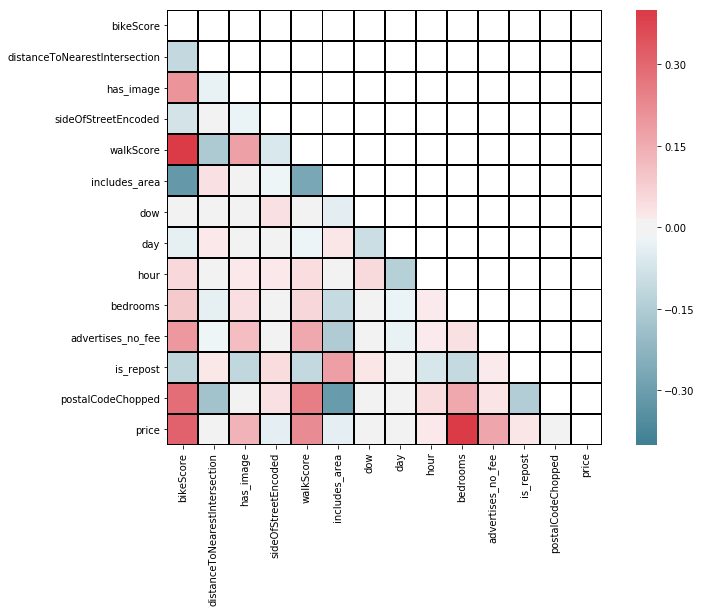

In [165]:
correlations = df_shrunk.corr()
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlations, mask=mask,
            cmap=cmap, linewidths=1, linecolor='#000000',
           square=True, vmax=.4, vmin=-.4)

### What we see in the correlation heatmap:
- Price is positively correlated with bedrooms, walkScore and bikeScore. Bike score is likely a proxy for living in Manhattan, as the city is going to have very good scores. 
- There tends to be higher prices for apartments that post an image
- Interestingly apartments advertising that they don't charge a fee actually have higher prices
- We have some colinearity among things like walkScore and bikeScore and postalCode and bedrooms.

## Univariate analysis

### Histogram of prices
The histogram below shows what one often sees with real estate data - a heavy right skew. As one can imagine there are some absurdly expensive apartments and condos in New York. It also looks like our mean price is around 2.5-3k a month.

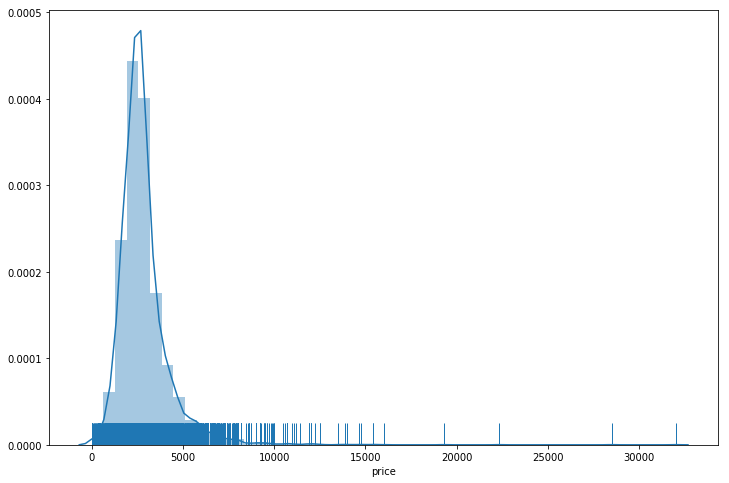

In [166]:
sns.distplot(df_dedup['price'], rug=True)

### Price by number of bedrooms
No surprise here as the price goes up with the number of bedrooms. Interestingly we see a drop for 6 BR but this is likely due to a small sample size (how many 6BR can really exist in New York City)

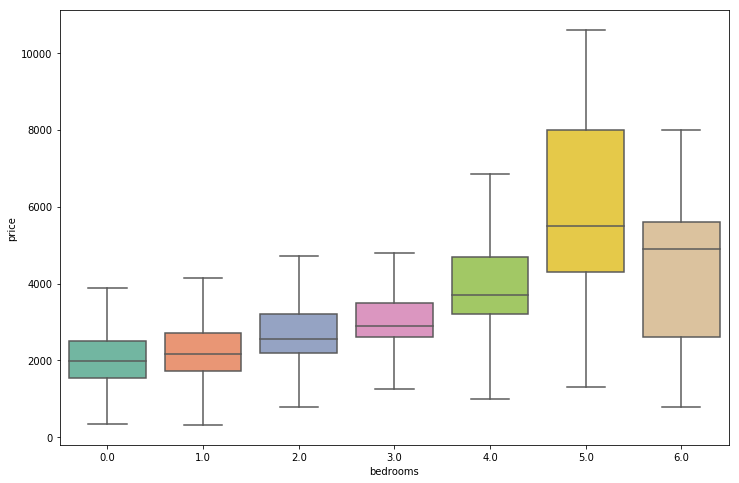

In [167]:
ax = sns.boxplot(x='bedrooms', y='price', 
                 data=df_dedup, palette="Set2", 
                 showfliers=False)

### Price by has_image
Here we see apartments that do show an image in the ad have a significant price increase over the alternative. Likely this is due to the fact that nicer apartments will have nothing to hide and post pictures while the same may not be said for the other case.

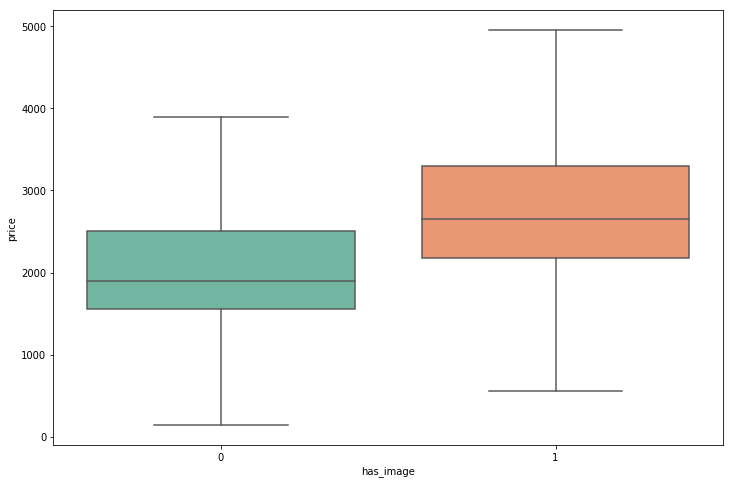

In [168]:
ax = sns.boxplot(x='has_image', y='price', data=df_dedup, palette="Set2", showfliers=False)

### Price by zip code

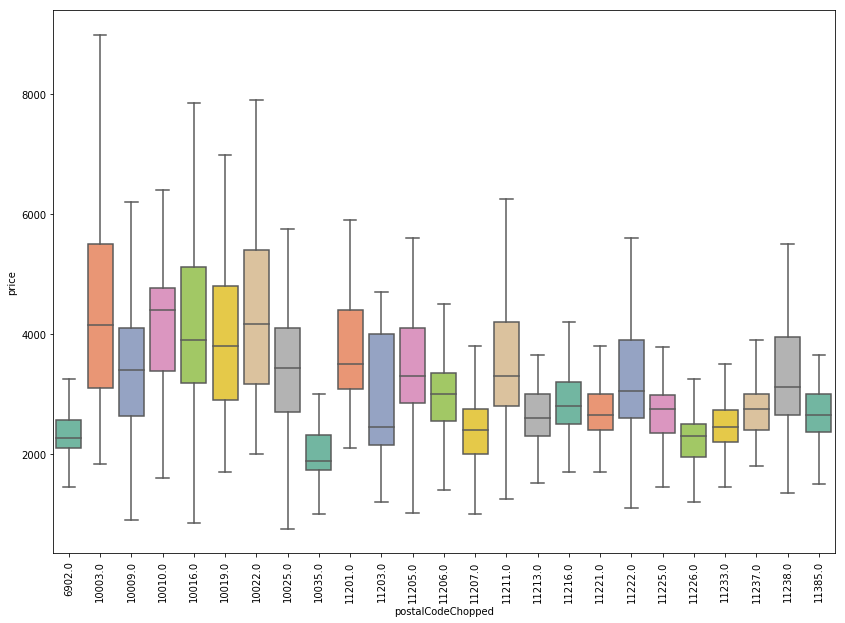

In [169]:
# Limit to top 25 neighborhoods by apartment count
df_top_25_hoods = (df_dedup[df_dedup['postalCodeChopped']
                            .isin(df_dedup['postalCodeChopped']
                            .value_counts().head(25).index)])
df_top_25_hoods['postalCodeChopped'].value_counts()
fig, ax = plt.subplots(figsize=(14,10))
plt.xticks(rotation=90)
ax = sns.boxplot(x='postalCodeChopped', y='price', 
                 data=df_top_25_hoods, palette="Set2",
                showfliers=False)

### Count of apartments by neighborhood

### Price for whether or not they advertise "No Fee"
As we saw in the correlation matrix, there tend to be higher prices for apartments advertising no fee.

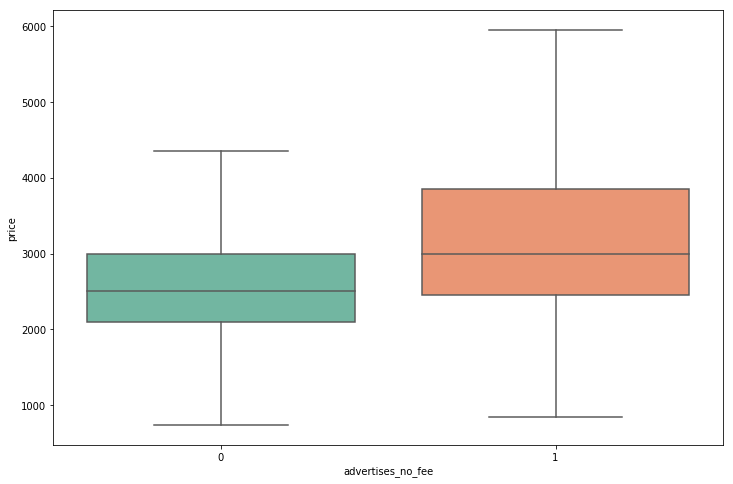

In [170]:
ax = sns.boxplot(x='advertises_no_fee', y='price', 
                 data=df, palette="Set2",
                showfliers=False)

### Square Footage
I always read about how tiny New York City apartments are - let's see what the data tells us. Here we will overlay four different distributions - overall, 1 bedrooms, 2 bedrooms and 3 bedrooms.

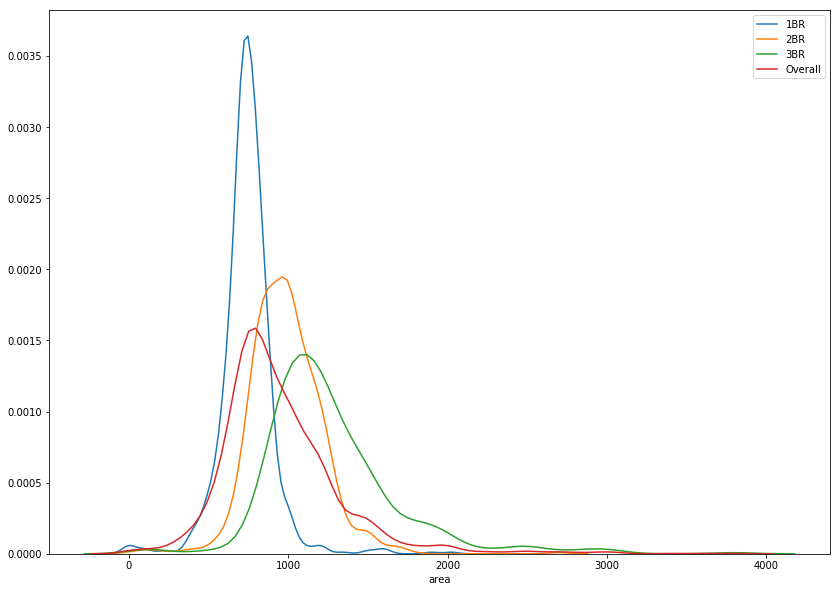

In [171]:
df_has_area = df_dedup.dropna(subset=['area', 'bedrooms'], axis=0)

# We have some outliers so we only look at apartments under 4000 SF
df_has_area = df_has_area[df_has_area['area'] < 4000]
fig, ax = plt.subplots(figsize=(14, 10))
sns.distplot(df_has_area[df_has_area['bedrooms']==1]['area'], label='1BR', hist=False)
sns.distplot(df_has_area[df_has_area['bedrooms']==2]['area'], label='2BR', hist=False)
sns.distplot(df_has_area[df_has_area['bedrooms']==3]['area'], label='3BR', hist=False)
sns.distplot(df_has_area['area'], label='Overall', hist=False)
ax.legend()

## Bivariate Analysis

### Area vs. Price
We have limited apartments that actually list the area but let's see how square footage increases with increasing the number of bedrooms

In [172]:
# Create string field for our color mapper
df_has_area['bedrooms_string'] = df_has_area['bedrooms'].astype(str) + " Bedrooms"
cmap = factor_cmap('bedrooms_string', palette=Spectral6, factors=df_has_area['bedrooms_string'].unique())

# Create figure
source = ColumnDataSource(df_has_area)
p = figure(sizing_mode='stretch_width', title="SQFT vs. Price", tools=[], toolbar_location=None)
p.scatter(x='area', y='price', source=source, legend='bedrooms_string',
          size=15, alpha=.6, fill_color=cmap, line_color='#000000', line_width=2)
p.legend.location = 'bottom_right'
p.xaxis.axis_label = "Square Feet"
p.yaxis.axis_label = "Price ($)"
p.y_range = Range1d(0, df_has_area['price'].max()*1.05)
show(p)

### Walk Score vs. Bike Score
Many algorithms will later not play nice with features that are perfectly correlated. While both features may be interesting to an individual it may be best to either only use one or a combination of the two in our model.

In [173]:
# Get Correlation
walkBikeScore_df = df_dedup[['bikeScore', 'walkScore']].dropna(axis=0)
walkBikeCorr = pearsonr(walkBikeScore_df['bikeScore'].values, walkBikeScore_df['walkScore'].values)[0]

source = ColumnDataSource(df_dedup)
p = (figure(sizing_mode='stretch_width', 
            title="Walk Score vs. Bike Score ({:.2%} Correlation)".format(walkBikeCorr), 
            tools=[], 
            toolbar_location=None))
     
p.scatter(x='walkScore', y='bikeScore', source=source)
p.xaxis.axis_label = "Walk Score (/100)"
p.yaxis.axis_label = "Bike Score (/100)"
# p.y_range = Range1d(0, df_has_area['price'].max()*1.05)
show(p)

### Price vs. Distance to Intersection
Are corner apartments more expensive? Our distance to intersection metric uses MapQuest data to see how far the address is from the closest intersection.

In [174]:
# Filter for no nulls
df_has_distance = df_dedup[df_dedup['distanceToNearestIntersection'].notnull()]
df_has_distance = (df_has_distance[(df_has_distance['distanceToNearestIntersection'] < 175) 
                                   & (df_has_distance['price'] < 5000)])
# Create the figure
source = ColumnDataSource(df_has_distance)
p = (figure(title="Price vs. Distance to Intersection", 
            sizing_mode='stretch_width', 
           tools=[],
           toolbar_location=None))
p.scatter(x='distanceToNearestIntersection', y='price', line_width=2, color='#2e485c', source=source)
show(p)

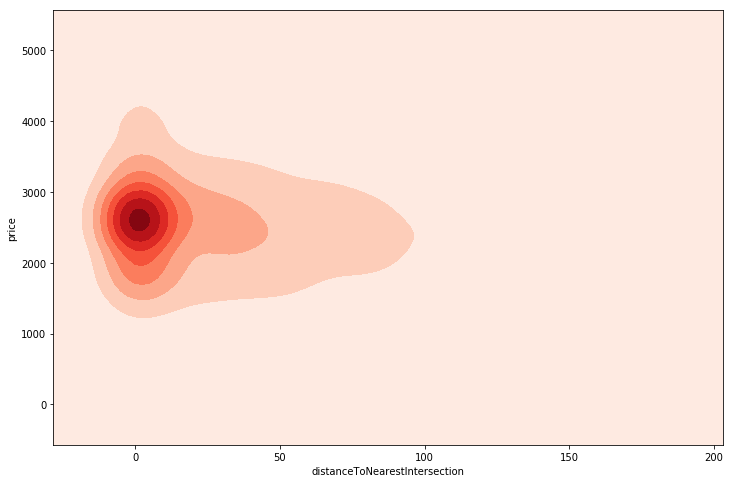

In [175]:
sns.kdeplot(df_has_distance['distanceToNearestIntersection'], df_has_distance['price'], shade=True, cmap="Reds")

## Prices using time variables

### Prices over time

In [176]:
df_dedup['datetime'] = pd.to_datetime(df_dedup['datetime'], format='%Y-%m-%d %H:%M:%S')
df_price_per_day = df_dedup.set_index('datetime')[['price']]
df_price_per_day = df_price_per_day.resample('d').median().reset_index()

In [177]:
# Create the plot
source = ColumnDataSource(df_price_per_day)
p = (figure(title="NYC Apartment Median Price Over Time", 
            sizing_mode='stretch_width', 
            x_axis_type='datetime',
           tools=[],
           toolbar_location=None))
p.line(x='datetime', y='price', line_width=2, color='#2e485c', source=source)
p.y_range = Range1d(0, df_price_per_day['price'].max()*1.05)
show(p)

### Prices by Day Of Week

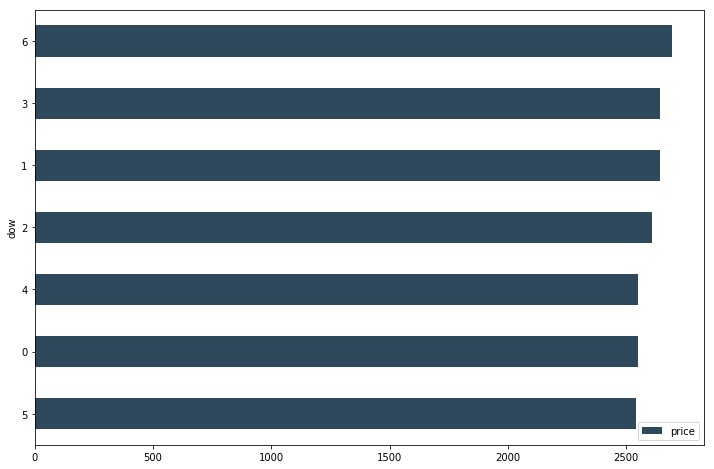

In [178]:
(df_dedup.groupby('dow')[['price']]
     .median()
     .sort_values('price')
     .plot(kind='barh', color='#2e485c'))